In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
def get_mrs_fitness(x, mrs, optim_fn, n_samples=None):
    for _ in range(x.ndim):
        mrs = mrs[..., None]
    shape = list(x.shape)
    if n_samples is not None:
        shape = [n_samples] + shape
        mrs = mrs[..., None]
    xmut = x+torch.randn(shape).to(x)*mrs
    fit_diff = optim_fn(xmut) - optim_fn(x)
    return x, xmut, fit_diff

In [5]:
def graph_data(x=None, y=None):
    if type(y) is torch.Tensor:
        y = y.numpy()
    
    ymin, ymax = y.min(axis=-1), y.max(axis=-1)
    plt.plot(y.mean(axis=-1), c='b');
    plt.plot(ymin, c='b');
    plt.plot(ymax, c='b');
#     a, b = fits.min(dim=-1).values, fits.max(dim=-1).values
    if x is None:
        x = np.arange(len(y))
    plt.errorbar(x, (ymax+ymin)/2., yerr=(ymax-ymin)/2., c='r')

graph_data(None, fits)
plt.yscale('log')
plt.ylim(5, 20)

NameError: name 'fits' is not defined

# Sample Mutation Rates Delta Fitness Distributions

In [4]:
mrs = torch.logspace(-1, 1.5, 16)
x = torch.randn(10000, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
print(fit_diff.shape)
best_mrs = mrs[fit_diff.min(dim=-1).values.argsort()]

torch.Size([16, 10000])


In [5]:
fit_diff.min(), fit_diff.max()

(tensor(-8.2655), tensor(22.1588))

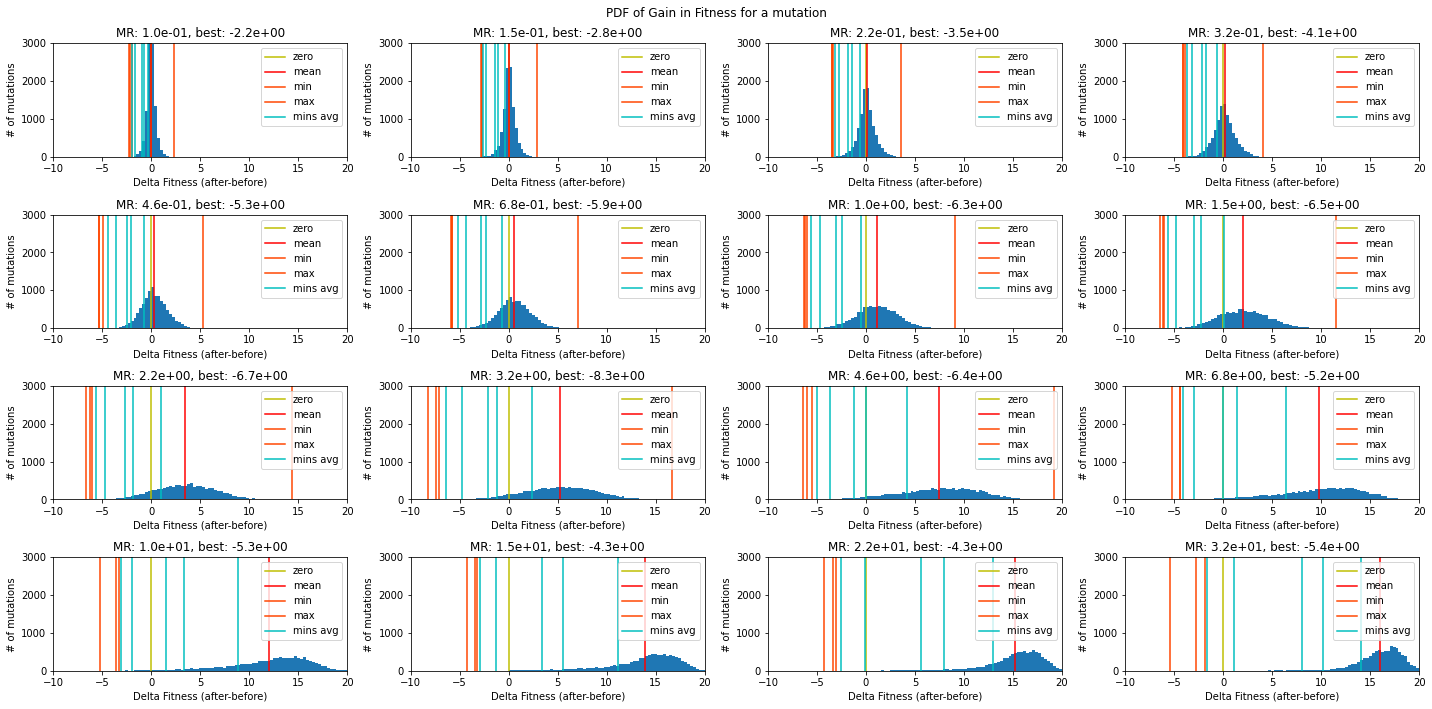

In [6]:
def viz_mrs_fit_hists(mrs, x, xmut, fit_diff):
    mrs = mrs[torch.arange(0, len(mrs), len(mrs)/16).to(int)]
    plt.figure(figsize=(20, 10))
    for i, mr in enumerate(mrs):
        fd = fit_diff[i]
        low, high = fit_diff.min(), fit_diff.max()
        low, high = -10, 20
        bins = np.linspace(low, high, 100)
        plt.subplot(4, 4, i+1)
        plt.hist(fd.cpu().numpy(), bins=bins);
        plt.axvline(c='y', label='zero')
        plt.axvline(fd.mean(), c='r', label='mean')
    #     plt.axvline(fd.min(), c='g', label='min')
        for i in range(3):
            plt.axvline(np.sort(fd)[i], c='orangered', label='min' if i==0 else None)
        plt.axvline(fd.max(), c='orangered', label='max')
        for i, ii in enumerate([10, 50, 500, 1000, 5000]):
            plt.axvline(fd.sort(dim=-1).values[:ii].mean(dim=-1), c='c', 
                     label='mins avg' if i==0 else None)
        plt.title(f'MR: {mr:.01e}, best: {fd.min():.01e}')
        plt.ylabel('# of mutations')
        plt.xlabel('Delta Fitness (after-before)')
        plt.xlim(low, high)
        plt.ylim(0,3000)
        plt.legend()
    plt.suptitle('PDF of Gain in Fitness for a mutation')
    plt.tight_layout()
    return plt.gcf()

viz_mrs_fit_hists(mrs, x, xmut, fit_diff).show()

# Mutation Rate vs Delta Fitness Distributions

In [13]:
mrs = torch.logspace(-1, 1.5, 100)
x = torch.randn(10000, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
print(fit_diff.shape)
best_mrs = mrs[fit_diff.min(dim=-1).values.argsort()]

torch.Size([100, 10000])


In [16]:
def calc_fd_bins_ns(fit_diff, fd_bins=None):
    if fd_bins is None:
        fd_bins = np.linspace(fit_diff.min(), fit_diff.max(), 101)
    ns = []
    for i, mr in enumerate(tqdm(mrs)):
        fd = fit_diff[i]
    #     n, _, chart = plt.hist(fd.cpu().numpy(), bins=bins)
        n, _  = np.histogram(fd.cpu().numpy(), bins=fd_bins)
        ns.append(n)
    ns = np.stack(ns)
    return ns


fd_bins = np.linspace(-10, 20, 101)
ns = calc_fd_bins_ns(fit_diff, fd_bins)
fd_bins = np.linspace(-10, 20, 100)
# fd_bins = np.linspace(-50, 100, 101)
# ns = calc_fd_bins_ns(fit_diff, fd_bins)
# fd_bins = np.linspace(-50, 100, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

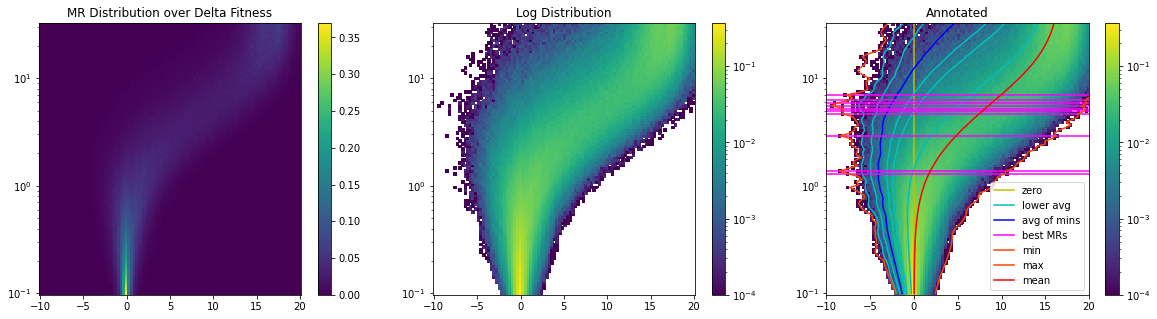

In [17]:
from matplotlib.colors import LogNorm
def viz_mrs_performance(mrs, fd_bins, ns, fit_diff):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    a, b = torch.meshgrid(torch.from_numpy(fd_bins).float(), mrs)
    plt.subplot(131)
    plt.pcolormesh(a, b, ns.T/ns.sum(axis=-1), shading='auto')
    plt.colorbar()
    plt.yscale('log')
    plt.title('MR Distribution over Delta Fitness')
    plt.subplot(132)
    plt.pcolormesh(a, b, ns.T/ns.sum(axis=-1), shading='auto', norm=LogNorm())
    plt.colorbar()
    plt.yscale('log')
    plt.title('Log Distribution')
    plt.subplot(133)
    plt.pcolormesh(a, b, ns.T/ns.sum(axis=-1), shading='auto', norm=LogNorm())
    plt.axvline(c='y', label='zero')
    # for i in range(1):
    #     plt.plot(fit_diff.sort(dim=-1).values[:, i], mrs, c='g', 
    #              label='best' if i==0 else None)
    for i, ii in enumerate([10, 50, 500, 1000, 5000]):
        plt.plot(fit_diff.sort(dim=-1).values[:, :ii].mean(dim=-1), mrs, c='c', 
                 label='lower avg' if i==0 else None)
    plt.plot(fit_diff.reshape(-1, 100, 100).min(dim=-1).values.mean(dim=-1), mrs, c='b', label='avg of mins')
    for i in range(10):
        plt.axhline(best_mrs[i], c='magenta', label='best MRs' if i==0 else None)
    plt.plot(fit_diff.min(dim=-1).values, mrs, c='orangered', label='min')
    plt.plot(fit_diff.max(dim=-1).values, mrs, c='orangered', label='max')
    plt.plot(fit_diff.mean(dim=-1), mrs, c='r', label='mean')
    plt.colorbar(); plt.legend()
    plt.yscale('log')
    plt.title('Annotated')
    plt.xlim(fd_bins.min(), fd_bins.max())
    
    for ax in axs:
        ax.set_ylabel('Mutation Rate')
        ax.set_xlabel('Delta Fitness (after-before)')
    return fig, axs

fig, axs = viz_mrs_performance(mrs, fd_bins, ns, fit_diff)
plt.show()

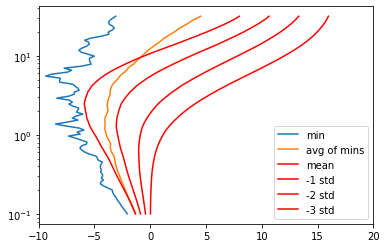

In [36]:
def viz_mr_min_std(mrs, fit_diff):
    a = fit_diff.min(dim=-1).values
    plt.plot(a, mrs, label='min')
    a = fit_diff.reshape(100, 100, 100).min(dim=-1).values.mean(dim=-1)
    plt.plot(a, mrs, label='avg of mins')

    a = fit_diff.mean(dim=-1)
    plt.plot(a, mrs, c='r', label='mean')
    a = fit_diff.mean(dim=-1)-fit_diff.std(dim=-1)
    plt.plot(a, mrs, c='r', label='-1 std')
    a = fit_diff.mean(dim=-1)-2*fit_diff.std(dim=-1)
    plt.plot(a, mrs, c='r', label='-2 std')
    a = fit_diff.mean(dim=-1)-3*fit_diff.std(dim=-1)
    plt.plot(a, mrs, c='r', label='-3 std')

    plt.legend()
    plt.xlim(-10, 20)
    plt.yscale('log')
    return plt.gcf()
viz_mr_min_std(mrs, fit_diff).show()

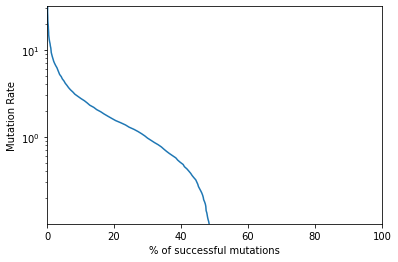

In [24]:
def viz_mr_percent(mrs, x, xmut, fit_diff):
    plt.plot((fit_diff<0).sum(dim=-1)/fit_diff.shape[-1]*100, mrs)
    plt.yscale('log')
    plt.ylabel('Mutation Rate'); plt.xlabel('% of successful mutations')
    plt.ylim(mrs.min(), mrs.max())
    plt.xlim(0,100)
viz_mr_percent(mrs, x, xmut, fit_diff)

Text(0.5, 0, '% successful mutation')

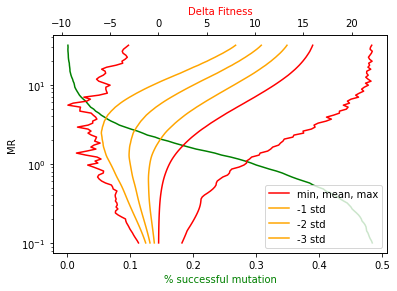

In [47]:
fig, ax1 = plt.subplots()
plt.yscale('log')

ax2 = ax1.twiny()
# a = fit_diff.min(dim=-1).values.min().abs().item()
# ax2.set_xlim(-a, a)
ax1.plot((fit_diff<0).sum(dim=-1)/fit_diff.shape[-1], mrs, c='g')


ax2.plot(fit_diff.mean(dim=-1), mrs, 'r-', label='min, mean, max')
ax2.plot(fit_diff.min(dim=-1).values, mrs, 'r-')
ax2.plot(fit_diff.max(dim=-1).values, mrs, 'r-')

a = fit_diff.mean(dim=-1)-fit_diff.std(dim=-1)
ax2.plot(a, mrs, c='orange', label='-1 std')
a = fit_diff.mean(dim=-1)-2*fit_diff.std(dim=-1)
ax2.plot(a, mrs, c='orange', label='-2 std')
a = fit_diff.mean(dim=-1)-3*fit_diff.std(dim=-1)
ax2.plot(a, mrs, c='orange', label='-3 std')


plt.legend()
ax1.set_ylabel('MR')
ax2.set_xlabel('Delta Fitness', color='r')
ax1.set_xlabel('% successful mutation', color='g')

In [141]:
mrs = torch.logspace(-1, 1.5, 32)
x = torch.randn(10000, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
print(fit_diff.shape)

torch.Size([32, 10000])


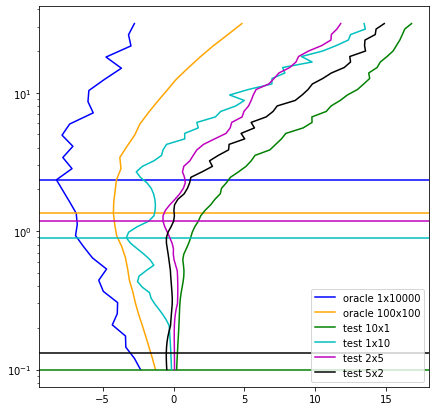

In [142]:

plt.figure(figsize=(7,7))
a = fit_diff.min(dim=-1).values
plt.plot(a, mrs, label='oracle 1x10000', c='b')
plt.axhline(mrs[a.argmin()], c='b')
a = fit_diff.reshape(-1, 100, 100).min(dim=-1).values.mean(dim=-1)
plt.plot(a, mrs, label='oracle 100x100', c='orange')
plt.axhline(mrs[a.argmin()], c='orange')


mrs = torch.logspace(-1, 1.5, 64)
x = torch.randn(10, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
a = fit_diff.reshape(-1, 10, 1).min(dim=-1).values.mean(dim=-1)
plt.plot(a, mrs, label='test 10x1', c='g')
plt.axhline(mrs[a.argmin()], c='g')
x = torch.randn(10, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
a = fit_diff.reshape(-1, 1, 10).min(dim=-1).values.mean(dim=-1)
plt.plot(a, mrs, label='test 1x10', c='c')
plt.axhline(mrs[a.argmin()], c='c')
x = torch.randn(10, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
a = fit_diff.reshape(-1, 2, 5).min(dim=-1).values.mean(dim=-1)
plt.plot(a, mrs, label='test 2x5', c='m')
plt.axhline(mrs[a.argmin()], c='m')
x = torch.randn(10, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
a = fit_diff.reshape(-1, 5, 2).min(dim=-1).values.mean(dim=-1)
plt.plot(a, mrs, label='test 5x2', c='k')
plt.axhline(mrs[a.argmin()], c='k')

plt.legend()
plt.yscale('log')

In [99]:
optim_fn = ackley
mrs = torch.logspace(-1, 1.5, 16)
x = torch.randn(2)
x = torch.tensor([1.5,1.5])
xp = x+(mrs[:, None, None] * torch.randn(1, 1000, 2))
fitb = optim_fn(x)
fita = optim_fn(xp)
fit_diff = fita-fitb
print(fit_diff.shape)
# best_mrs = mrs[fit_diff.min(dim=-1).values.argsort()]

torch.Size([16, 1000])


In [100]:
bound = 3
a = torch.linspace(-bound, bound, 100)
b = torch.linspace(-bound, bound, 100)
a, b = torch.meshgrid(a,b)

c = torch.stack([a,b],dim=-1)
c = ackley(c)


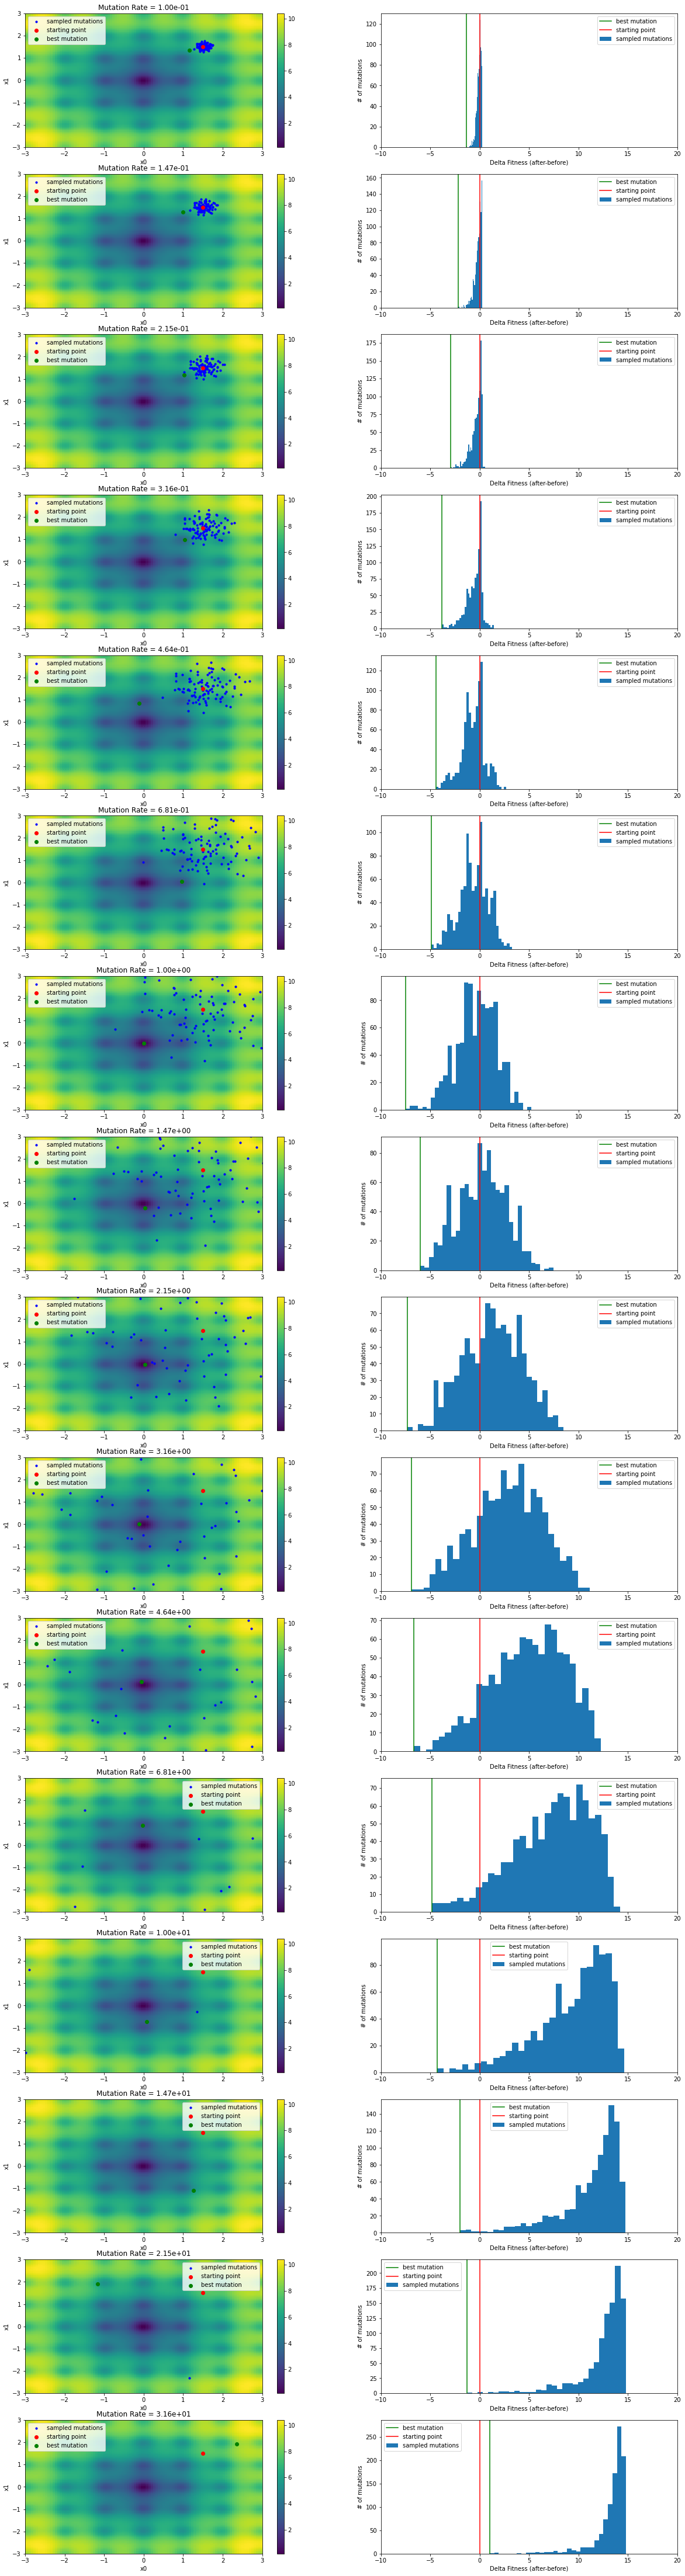

In [109]:
plt.figure(figsize=(20,5*len(mrs)))
for i, mr in enumerate(mrs):
    plt.subplot(len(mrs), 2, i*2+1)
    plt.title(f'Mutation Rate = {mr:.02e}')
    plt.pcolormesh(a, b, c, shading='auto')
    plt.colorbar()
    plt.scatter(*xp[i][::10].T, c='b', s=10, label='sampled mutations')
    plt.scatter(*x, c='r', label='starting point')
    plt.scatter(*xp[i][fit_diff[i].argmin()], c='g', label='best mutation')
    plt.legend()
    plt.ylabel('x1'); plt.xlabel('x0')
    plt.xlim(a.min(), a.max()); plt.ylim(b.min(), b.max())
    plt.subplot(len(mrs), 2, i*2+2)
    plt.hist(fit_diff[i].numpy(), bins=30, label='sampled mutations')
    plt.axvline(fit_diff[i].min(), c='g', label='best mutation')
    plt.axvline(c='r', label='starting point')
    plt.ylabel('# of mutations'); plt.xlabel('Delta Fitness (after-before)')
    plt.xlim(-10, 20)
    plt.legend()
plt.show()

In [33]:
pops = torch.randn(20, 101, 30)
mrs = torch.logspace(-2, 2, 32)

In [34]:
get_mrs_fitness(pops, mrs, ackley).shape

torch.Size([32, 20, 101])

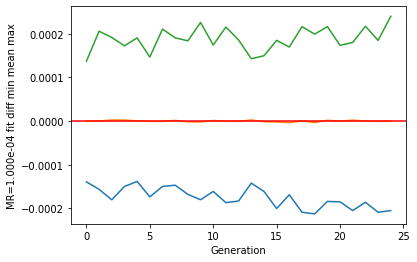

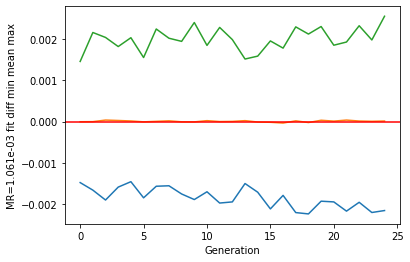

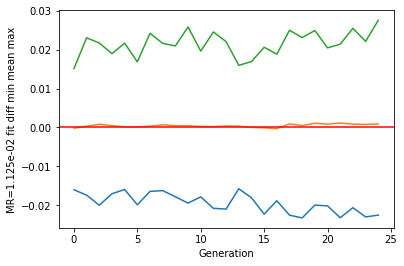

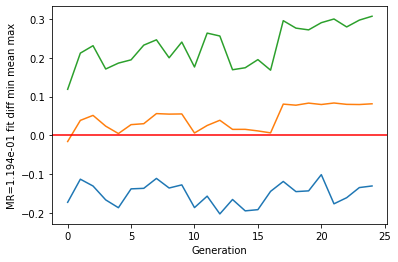

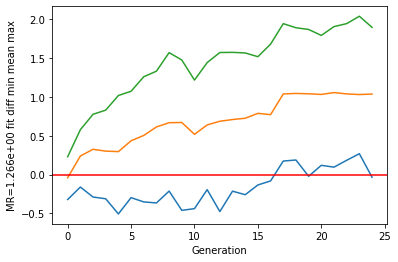

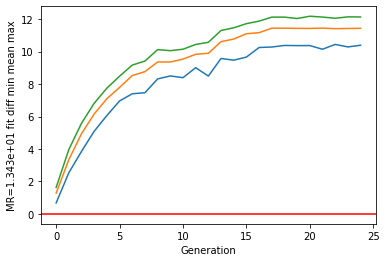

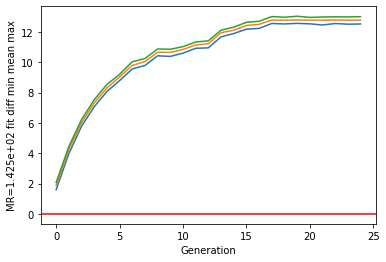

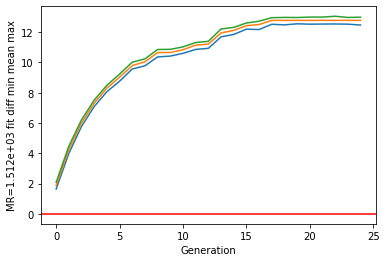

In [20]:
for i in range(0, 40, 5):
    mr = mrs[i]
    plt.plot(x.min(dim=1).values[i]);
    plt.plot(x.mean(dim=1)[i]);
    plt.axhline(c='r')
    plt.plot(x.max(dim=1).values[i]);
    plt.ylabel(f'MR={mr:.03e} fit diff min mean max')
    plt.xlabel('Generation')
    plt.show()

Text(0.5, 1.0, 'Percentage of successful mutations - MR vs Generation')

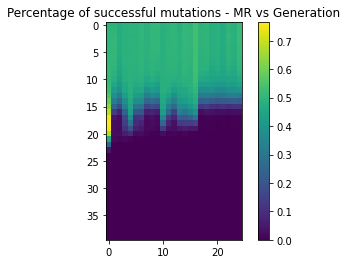

In [21]:
plt.imshow((x<0).sum(dim=1).numpy()/999)
plt.colorbar()
plt.title('Percentage of successful mutations - MR vs Generation')

Text(0.5, 1.0, 'Best sampled difference - MR vs Generation')

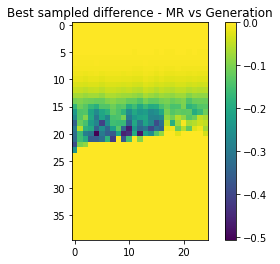

In [22]:
a = x.min(dim=1).values.numpy()
a[a>0]=0
plt.imshow(a)
plt.colorbar()
plt.title('Best sampled difference - MR vs Generation')

Text(0.5, 1.0, 'Best sampled difference - MR vs Generation')

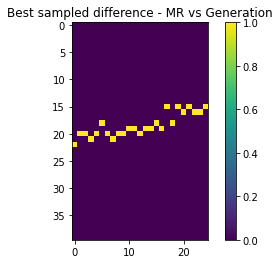

In [35]:
a = x.min(dim=1).values.numpy()
a[a>0]=0
a = (a==np.sort(a, axis=0)[0])
plt.imshow(a)
plt.colorbar()
plt.title('Best sampled difference - MR vs Generation')

  0%|          | 0/5 [00:00<?, ?it/s]

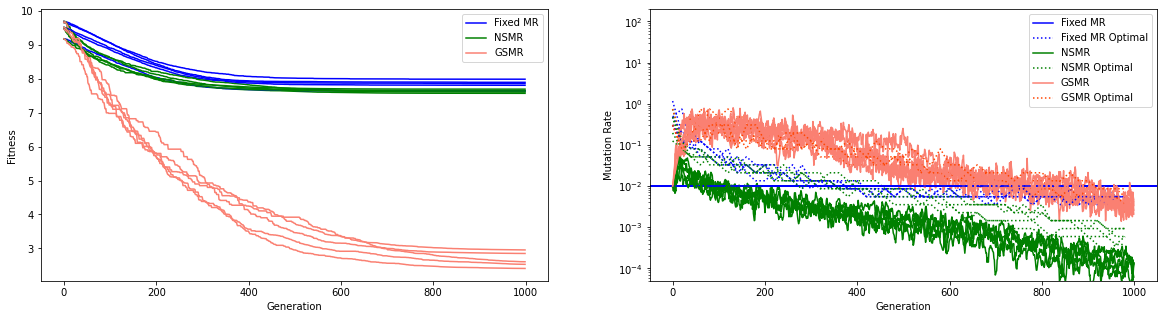

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))

for i in tqdm(range(5)):
    do_seed(i)
#     pop = torch.randn(101, 2)+10
#     pop = torch.randn(101, 100)*5+5 # GOOD
#     pop = torch.randn(101, 100)*.1+1
#     pop = torch.randn(101, 1000)*.1+.3
    pop = torch.randn(101, 100)*3 # GOOD
#     pop = torch.full((101, 100), 0.9684)
    
    n_gen, mr = 1000, 1e-2
    optim_fn = ackley

    mrs = torch.logspace(-4, 2, 32)
    gens = torch.arange(0, n_gen, 20)


    pops, fits = optim.run_evolution_base(pop, optim_fn, n_gen, mr=mr, tqdm=None)
    axs[0].plot(fits.min(dim=-1).values, c='b', label='Fixed MR' if i==0 else None)
    axs[1].axhline(mr, c='b', label='Fixed MR' if i==0 else None)
    
#     _, _, fit_mrs = get_mrs_fitness(pops[gens], mrs, optim_fn)
    _, _, fit_mrs = get_mrs_fitness(pops[gens, 0], mrs, optim_fn, 101)
    fit_mrs = fit_mrs.permute(0, 2, 1)
    
    best_mrs = mrs[fit_mrs.min(dim=-1).values.argmin(dim=0)]
    axs[1].plot(gens, best_mrs, c='b', linestyle='dotted', label='Fixed MR Optimal' if i==0 else None)

#     mr = None

    pops, fits, mutpops = optim.run_evolution_ns(pop, optim_fn, n_gen, mr=mr, tqdm=None)
    axs[0].plot(fits.min(dim=-1).values, c='g', label='NSMR' if i==0 else None)
    # axs[1].plot(mutpops[:, :, 0].min(dim=-1).values, c='g')
    axs[1].plot(mutpops[:, :, 0].log().mean(dim=-1).exp(), c='g', label='NSMR' if i==0 else None)
    # axs[1].plot(mutpops[:, :, 0].max(dim=-1).values, c='g')
    
#     _, _, fit_mrs = get_mrs_fitness(pops[gens], mrs, optim_fn)
    _, _, fit_mrs = get_mrs_fitness(pops[gens, 0], mrs, optim_fn, 101)
    fit_mrs = fit_mrs.permute(0, 2, 1)
    
    best_mrs = mrs[fit_mrs.min(dim=-1).values.argmin(dim=0)]
    axs[1].plot(gens, best_mrs, c='g', linestyle='dotted', label='NSMR Optimal' if i==0 else None)

    pops, fits, mutpops, fitmrs = optim.run_evolution_mutpops_full(pop, optim_fn, n_gen, n_mutpop=5, mr=mr, mr_mut=2.0, tqdm=None)
    axs[0].plot(fits.min(dim=-1).values, c='salmon', label='GSMR' if i==0 else None)
    # axs[1].plot(mutpops[:, :, 0].min(dim=-1).values, c='salmon')
    axs[1].plot(mutpops[:, :, 0].log().mean(dim=-1).exp(), c='salmon', label='GSMR' if i==0 else None)
    # axs[1].plot(mutpops[:, :, 0].max(dim=-1).values, c='salmon')

#     _, _, fit_mrs = get_mrs_fitness(pops[gens], mrs, optim_fn)
    _, _, fit_mrs = get_mrs_fitness(pops[gens, 0], mrs, optim_fn, 101)
    fit_mrs = fit_mrs.permute(0, 2, 1)
    
    
    
    best_mrs = mrs[fit_mrs.min(dim=-1).values.argmin(dim=0)]
    axs[1].plot(gens, best_mrs, c='orangered', linestyle='dotted', label='GSMR Optimal' if i==0 else None)

    axs[1].set_yscale('log')
    axs[1].set_ylim(mrs.min()/2, mrs.max()*2)


    axs[0].set_ylabel('Fitness'); axs[0].set_xlabel('Generation')
    axs[1].set_ylabel('Mutation Rate'); axs[1].set_xlabel('Generation')
    axs[0].legend(); axs[1].legend()
plt.show()

In [801]:
mrs[fit_mrs1.min(dim=-1).values.argmin(dim=0)]

tensor([1.0000e-04, 8.0025e-02, 1.2496e-01, 8.0025e-02, 8.0025e-02, 1.2496e-01,
        8.0025e-02, 5.1248e-02, 1.2496e-01, 8.0025e-02])

torch.Size([78, 10, 101])
torch.Size([78, 100, 10])


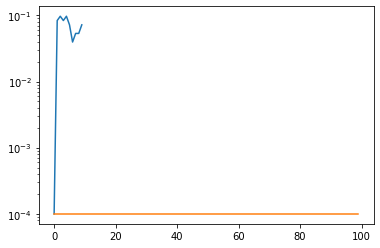

In [822]:
x, xmut, mrs_fit = get_mrs_fitness(pops1[::200], mrs, ackley)
print(mrs_fit.shape)
plt.plot(mrs[mrs_fit.min(dim=-1).values.argmin(dim=0)])
x, xmut, mrs_fit = get_mrs_fitness(pops1[::200, 0], mrs, ackley, 100)
print(mrs_fit.shape)
plt.plot(mrs[mrs_fit.min(dim=-1).values.argmin(dim=0)])
plt.yscale('log')

In [812]:
do_seed(0)
pops_base, fits_base = optim.run_evolution_base(pop, optim_fn, n_gen, mr=1e-1, tqdm=tqdm)
do_seed(0)
pops_ns, fits_ns, mutpops_ns = optim.run_evolution_ns(pop, optim_fn, n_gen, mr=mr, tqdm=tqdm)
do_seed(0)
pops, fits, mutpops, fitmrs = optim.run_evolution_mutpops_full(pop, optim_fn, n_gen, n_mutpop=5, mr=mr, tqdm=tqdm)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [813]:
x = pops_base[-1][0]
print(x.norm())

# x = torch.randn(100)
# x = x/x.norm()*pops[-1][0].norm()
print(x.norm())


mrs = torch.logspace(-4, 1, 78)

tensor(9.6840)
tensor(9.6840)


In [814]:
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley, 1000)

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  if __name__ == '__main__':


Text(0, 0.5, '% successful mutation')

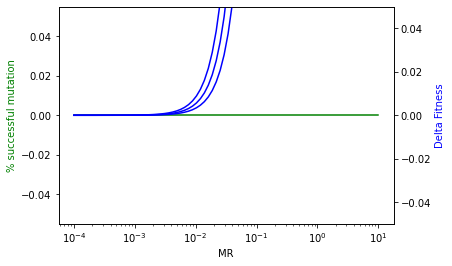

In [815]:
fig, ax1 = plt.subplots()
plt.xscale('log')

ax2 = ax1.twinx()
ax2.plot(mrs, fit_diff.mean(dim=-1), 'b-')
ax2.plot(mrs, fit_diff.min(dim=-1).values, 'b-')
ax2.plot(mrs, fit_diff.max(dim=-1).values, 'b-')
a = fit_diff.min(dim=-1).values.min().abs().item()
ax2.set_ylim(-a, a)
ax1.plot(mrs, (fit_diff<0).sum(dim=-1)/fit_diff.shape[-1], c='g')

ax1.set_xlabel('MR')
ax2.set_ylabel('Delta Fitness', color='b')
ax1.set_ylabel('% successful mutation', color='g')

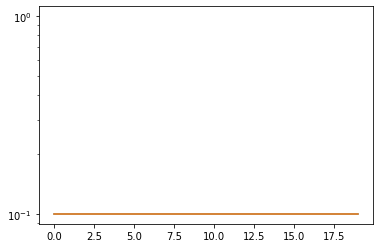

In [386]:
x, xmut, fit_diff = get_mrs_fitness(pops_ns[::100], mrs, optim_fn, 10)
plt.plot(mrs[fit_diff.min(dim=-1).values.mean(dim=1).argmin(dim=0)])
plt.yscale('log')
x, xmut, fit_diff = get_mrs_fitness(pops[::100], mrs, optim_fn, 10)
plt.plot(mrs[fit_diff.min(dim=-1).values.mean(dim=1).argmin(dim=0)])
plt.yscale('log')

In [301]:
x = pops[-1][0]
mrs = torch.logspace(-5, -1, 32)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, optim_fn, 10000)

fd_bins = np.linspace(-1e-2, 1e-2, 35)
ns = calc_fd_bins_ns(fit_diff, fd_bins)

  0%|          | 0/32 [00:00<?, ?it/s]

In [302]:
fit_diff.reshape(32, 1, -1).min(dim=-1).values.mean(dim=-1).argmin()

tensor(0)

In [303]:
ackley(x).item(), ackley(xmut).min().item()

(13.457073211669922, 13.457073211669922)

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of

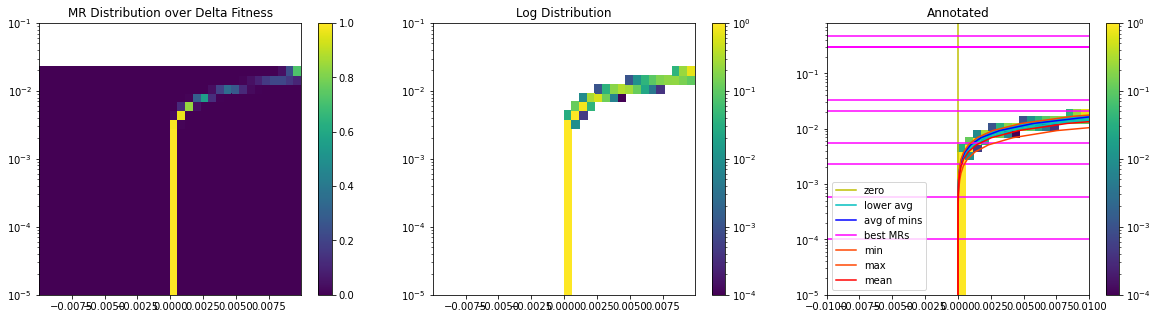

In [312]:
fig, axs = viz_mrs_performance(mrs, fd_bins, ns, fit_diff)
for ax in axs:
    plt.xlim(fd_bins.min(), fd_bins.max())
    ax.set_ylim(mrs.min(), mrs.max())
    ax.set_xlim(fd_bins.min(), fd_bins.max())
    
fig.show(0)

In [488]:
x = pops[-1][0].clone()
x = torch.ones(100)*.9686
x = torch.ones(100)*.9686+1e-2*torch.randn_like(x)
mrs = torch.logspace(-5, 1, 32)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, optim_fn, 10000)

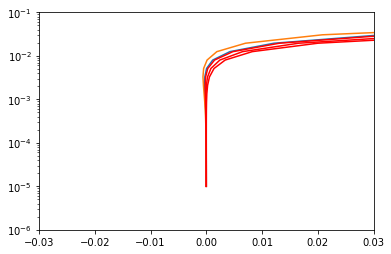

In [490]:
a = fit_diff.reshape(-1, 100, 100).min(dim=-1).values.mean(dim=-1)
plt.plot(a, mrs)
a = fit_diff.min(dim=-1).values
plt.plot(a, mrs)

a = fit_diff.mean(dim=-1)
plt.plot(a, mrs, c='r')
a = fit_diff.mean(dim=-1)-fit_diff.std(dim=-1)
plt.plot(a, mrs, c='r')
a = fit_diff.mean(dim=-1)-2*fit_diff.std(dim=-1)
plt.plot(a, mrs, c='r')
# a = fit_diff.mean(dim=-1)-3*fit_diff.std(dim=-1)
# plt.plot(a, mrs, c='r')

# plt.xlim(1e-6, 1e-4)
# plt.ylim(1e-6, 1e-2)


plt.ylim(1e-6, 1e-1)
plt.xlim(-1e-5, 1e-5)

# plt.ylim(1e-6, 1e-1)
plt.xlim(-3e-2, 3e-2)
plt.yscale('log')
# plt.xscale('log')